In [1]:
import itertools
import os
from tqdm import tqdm
import numpy as np

In [2]:
from glob import glob

In [15]:
import matplotlib.pylab as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=500)
plt.rcParams["figure.figsize"] = (10,8)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['seaborn-poster'])

In [6]:
import pyemma
import pickle
import numpy as np
from msmbuilder.utils import load,dump

/Users/arghya/opt/anaconda3/envs/msmbuilder/lib/python3.6/site-packages/pyemma/util/log.py:65: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)
/Users/arghya/opt/anaconda3/envs/msmbuilder/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)
/Users/arghya/opt/anaconda3/envs/msmbuilder/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=Dep

## AlphaFold Conformations

In [38]:
colvar=np.loadtxt('./COLVAR-AF/COLVAR-combined-use-alphafold')

In [35]:
chi1=colvar[:, 8]
chi2=colvar[:, 9]
d1=colvar[:, 1]

## PDB conformations

In [22]:
colvar2bju=np.loadtxt('./COLVAR-2bju')

In [24]:
chi12bju=colvar2bju[8]
chi22bju=colvar2bju[9]
d12bju=colvar2bju[1]
chi1tyr2bju=colvar2bju[5]
chi2tyr2bju=colvar2bju[6]

In [25]:
colvar1lf4=np.loadtxt('./COLVAR-1lf4')

In [26]:
chi11lf4=colvar1lf4[8]
chi21lf4=colvar1lf4[9]
d11lf4=colvar1lf4[1]
chi1tyr1lf4=colvar1lf4[5]
chi2tyr1lf4=colvar1lf4[6]

In [27]:
colvar4z22=np.loadtxt('./COLVAR-4z22')

In [28]:
chi14z22=colvar4z22[4]
chi24z22=colvar4z22[5]
d14z22=colvar4z22[1]
chi1tyr4z22=colvar4z22[2]
chi2tyr4z22=colvar4z22[3]

In [7]:
with open('/Users/arghya/Dropbox/prediction_plmii_fee78-jhammer-160/AF-adaptive-artur/Stride-20-trp/raw-features.pkl', 'rb') as f:
     features = pickle.load(f)

In [8]:
with open('/Users/arghya/Dropbox/prediction_plmii_fee78-jhammer-160/AF-adaptive-artur/Stride-20-trp/features.pkl', 'rb') as a:
     transfeatures = pickle.load(a)

In [9]:
#cocatenate features
features_concatenated = np.concatenate(features)

In [10]:
#cocatenate transformed features
transfeatures_concatenated = np.concatenate(transfeatures)

## Clustering

In [11]:
cluster = pyemma.coordinates.cluster_kmeans(transfeatures, k=100, max_iter=200, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

100%|██████████| 320/320 [00:00<00:00, 335.90it/s]                                    


## Timescale

In [13]:
%matplotlib inline

100%|██████████| 6/6 [00:03<00:00,  2.00it/s]                                 


Text(0, 0.5, 'timescale /ns')

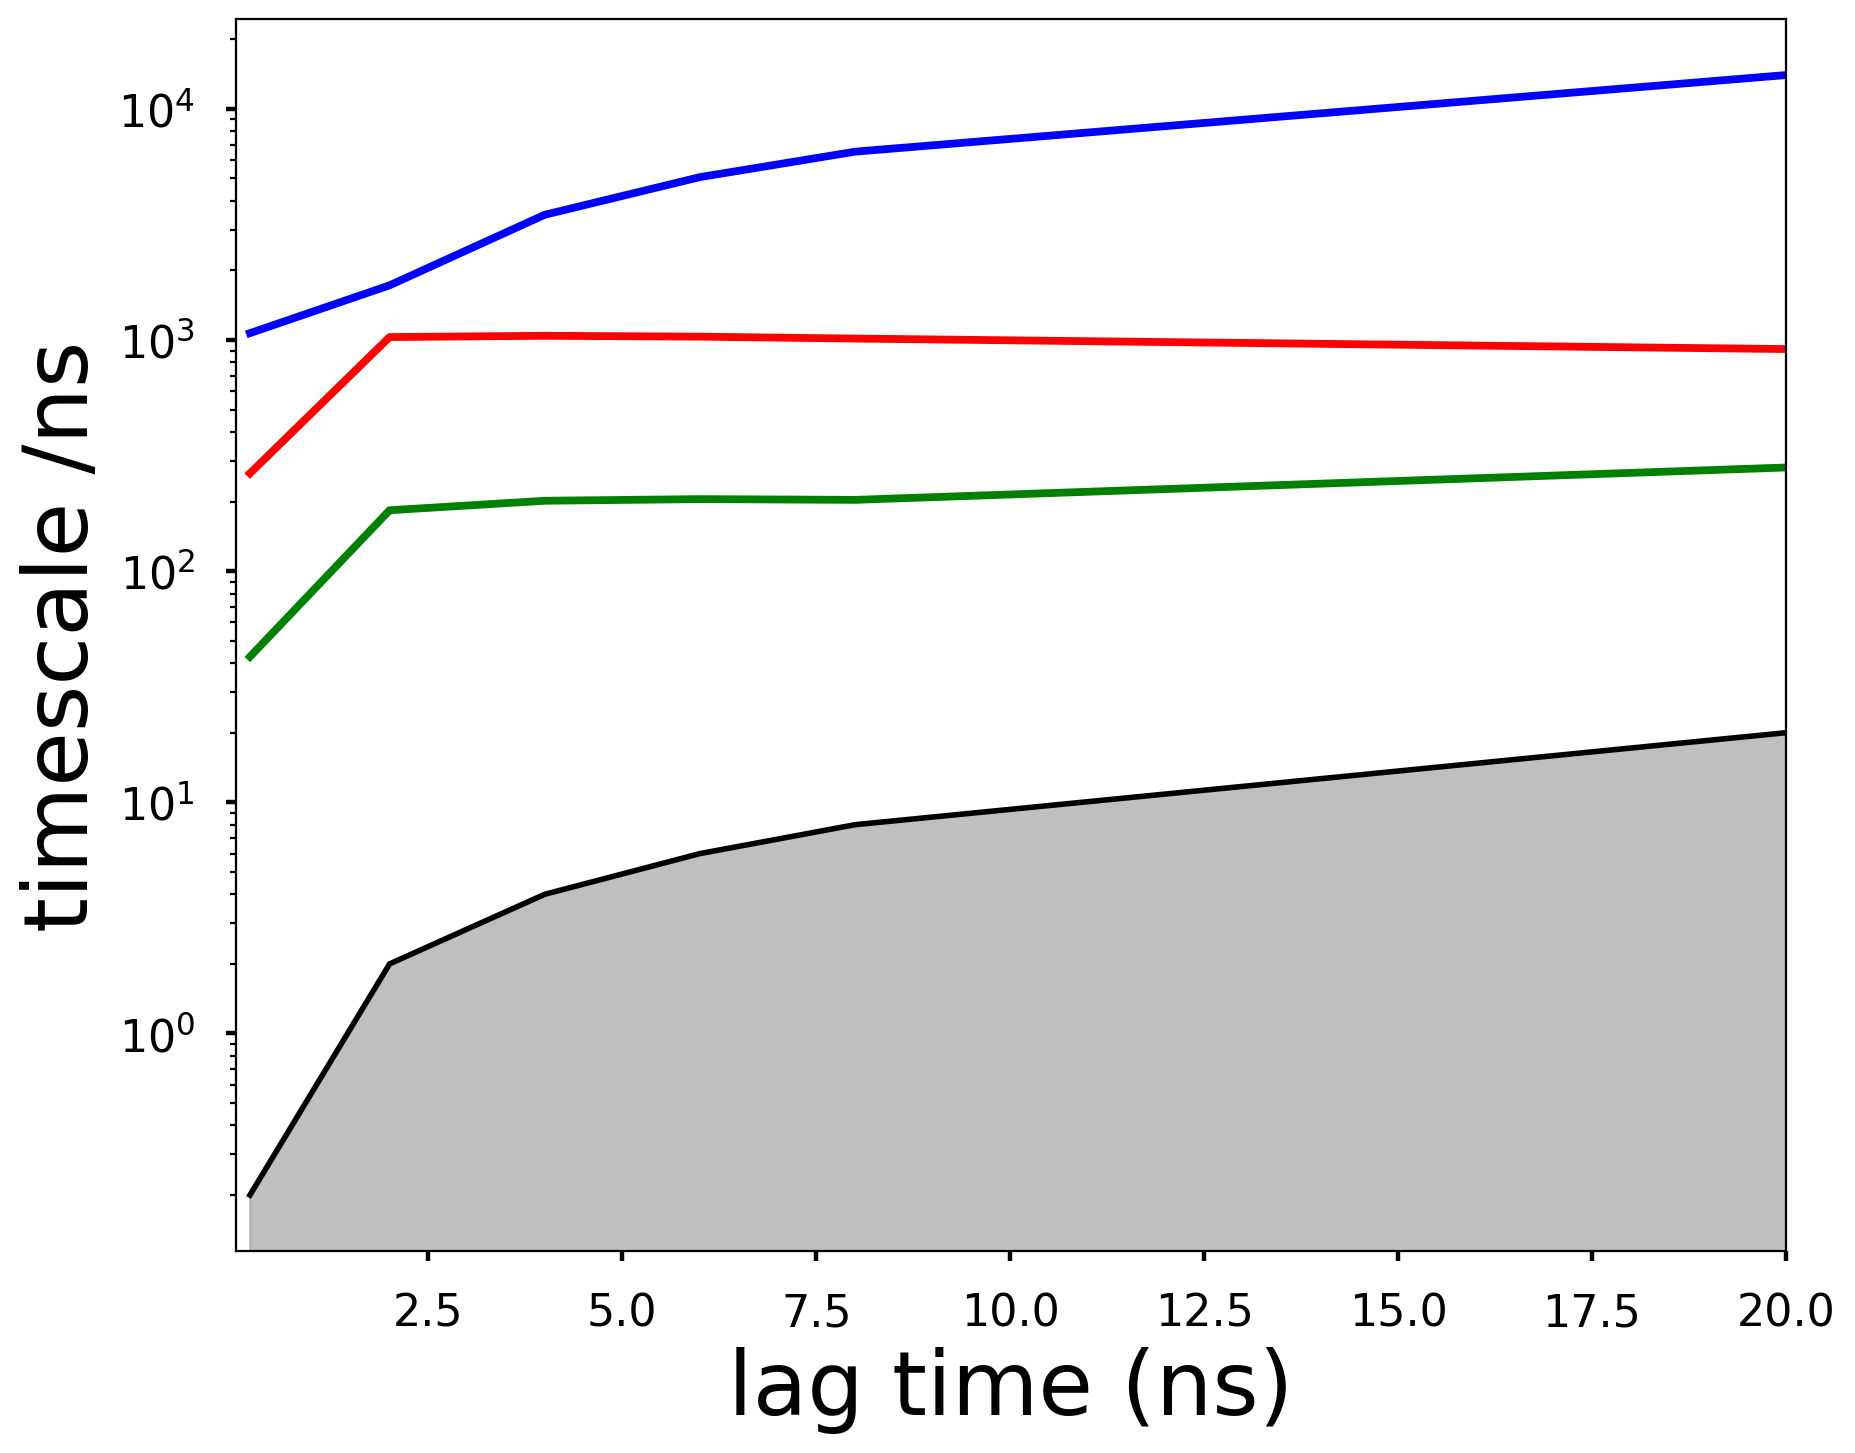

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
its = pyemma.msm.its(cluster.dtrajs, lags=[10, 100, 200, 300, 400, 1000], nits=3)
pyemma.plots.plot_implied_timescales(its, units='ns', dt=1/50);
ax.set_xlabel('lag time (ns)', fontsize=32)
ax.set_ylabel('timescale /ns', fontsize=32)

## MSM

In [18]:
lag = 10*50
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag)
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

100%|██████████| 100/100 [00:00<00:00, 207.13it/s]              

fraction of states used = 1.00
fraction of counts used = 1.00


## Free energy Surface

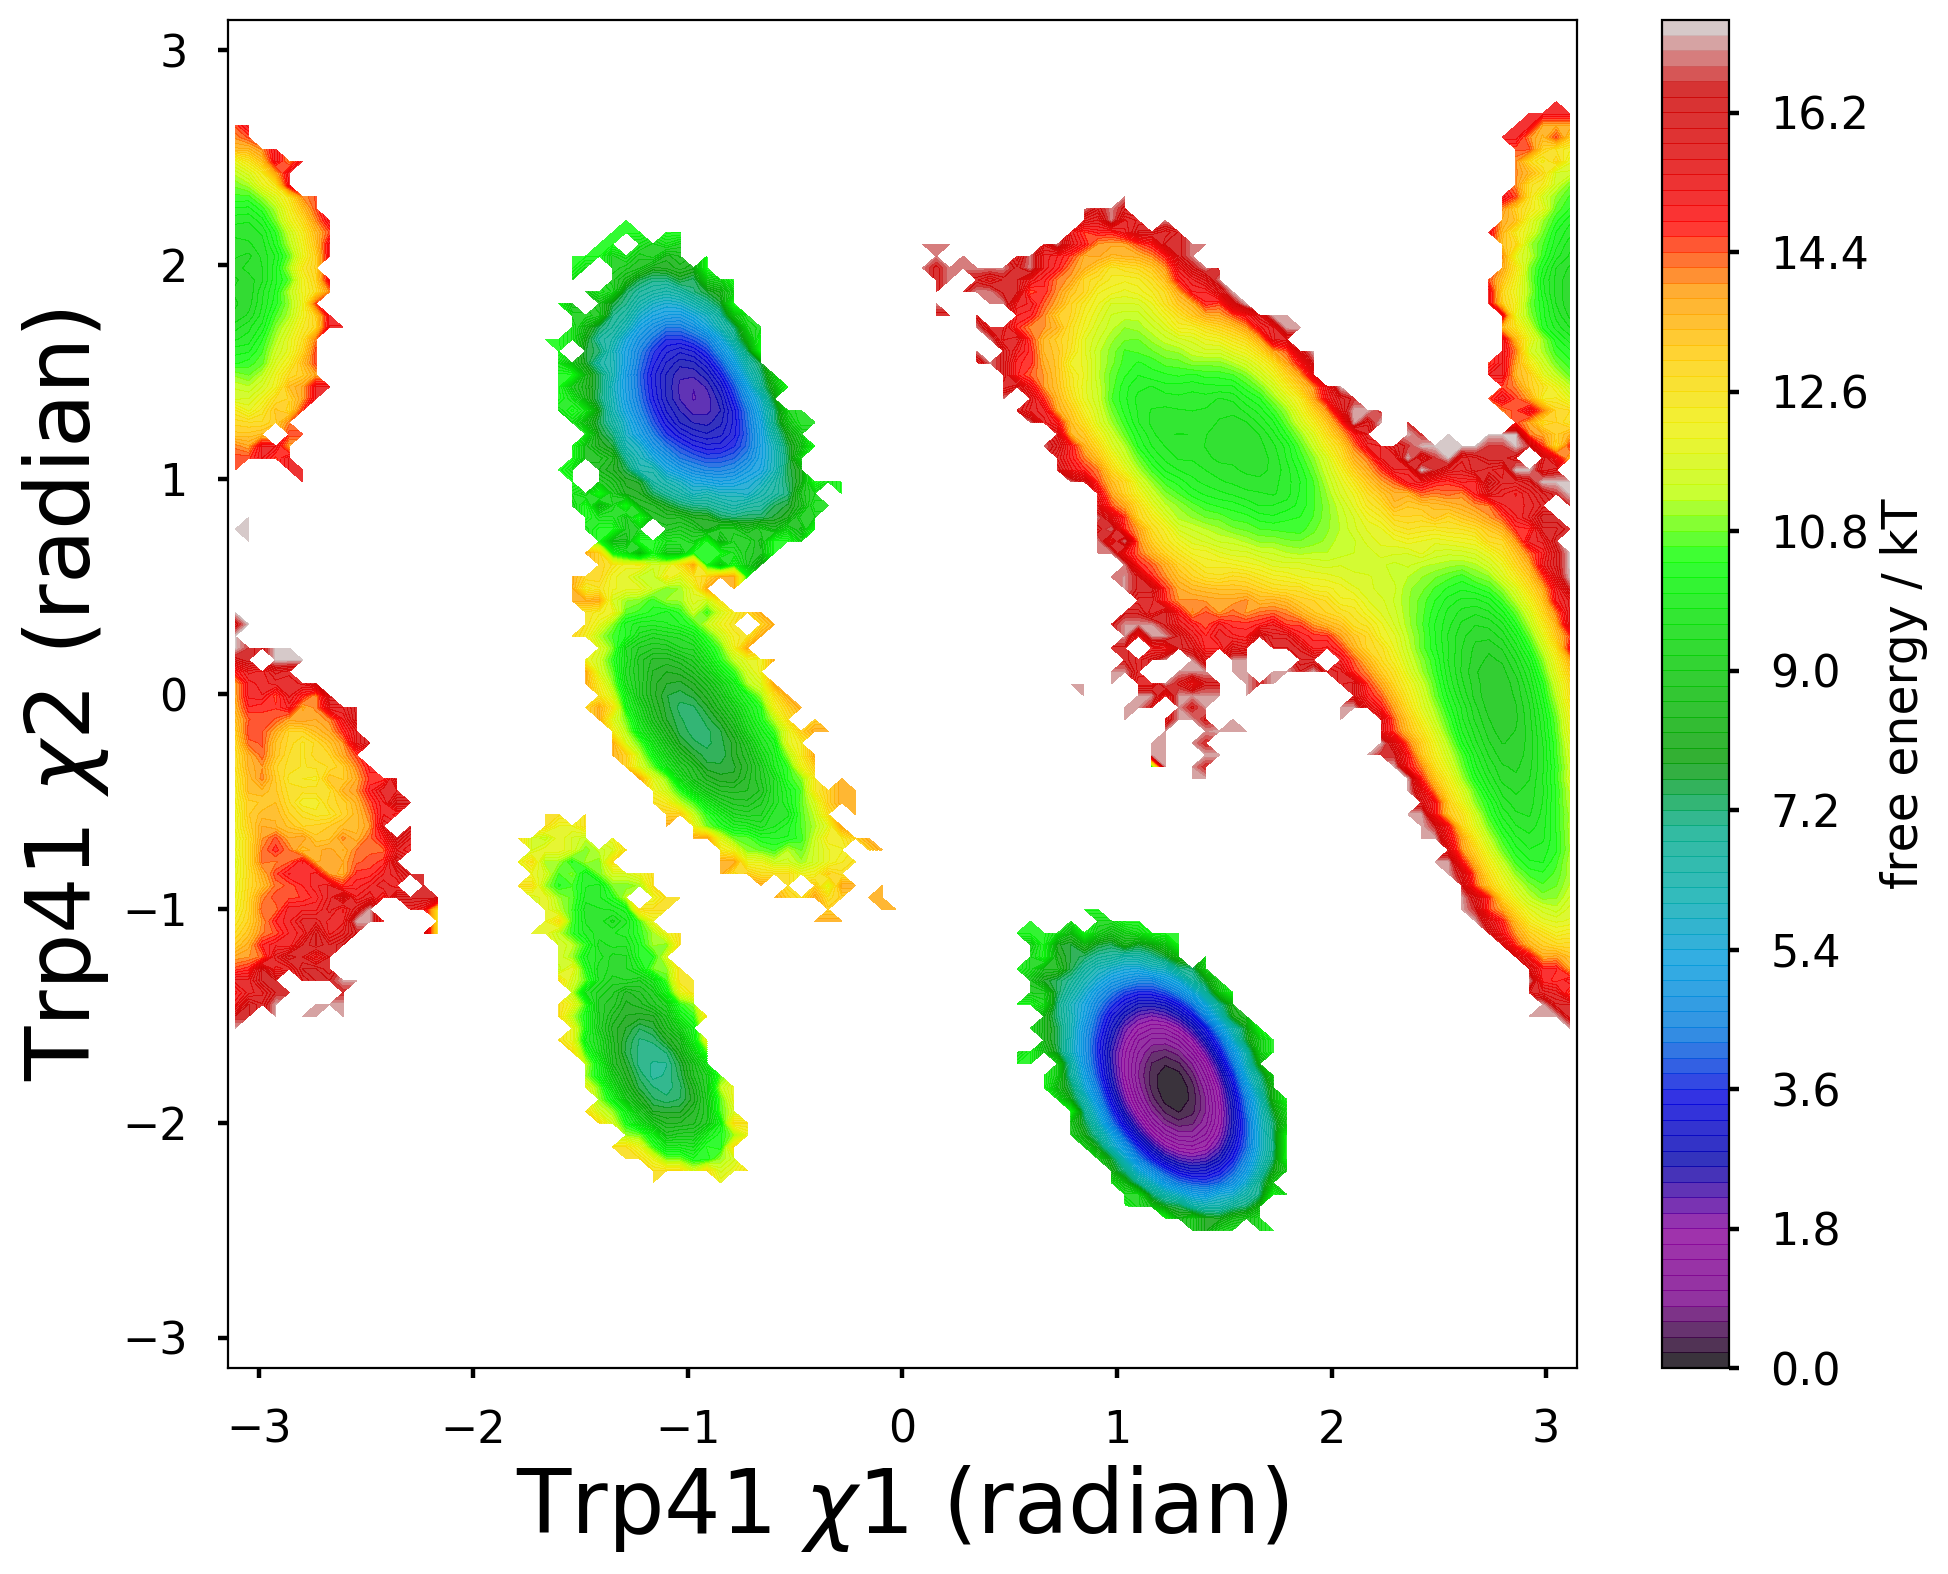

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
pyemma.plots.plot_free_energy(*features_concatenated[:, :2].T, weights=np.concatenate(msm.trajectory_weights()), ax=ax, legacy=False, alpha=0.8)
ax.set_xlabel('Trp41 $\chi1$ (radian)', fontsize=32)
ax.set_ylabel('Trp41 $\chi2$ (radian)', fontsize=32)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_aspect('equal')

fig.tight_layout()

## State definition

In [20]:
nstates = 6
msm.pcca(nstates)

PCCA(P=array([[0.04551, 0.     , ..., 0.03127, 0.03736],
       [0.     , 0.02198, ..., 0.     , 0.     ],
       ...,
       [0.04442, 0.     , ..., 0.03458, 0.0346 ],
       [0.042  , 0.     , ..., 0.02739, 0.03836]]),
   m=6)

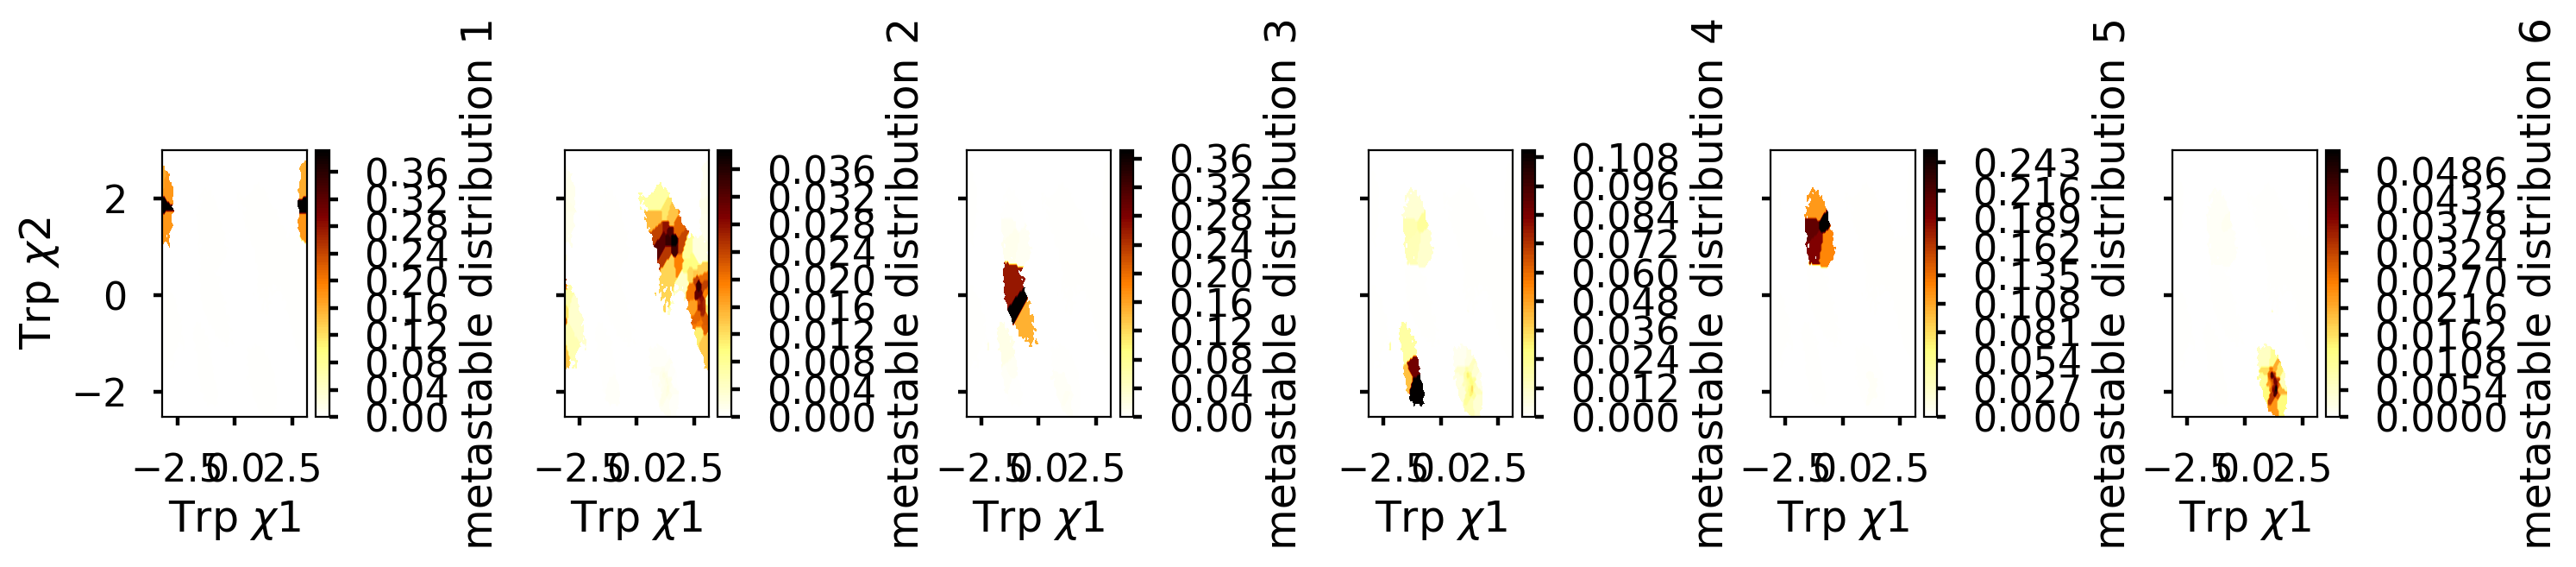

In [21]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *features_concatenated[:, :2].T,
        msm.metastable_distributions[i][np.concatenate(msm.dtrajs_active)],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('Trp $\chi1$')
axes[0].set_ylabel('Trp $\chi2$')
fig.tight_layout()

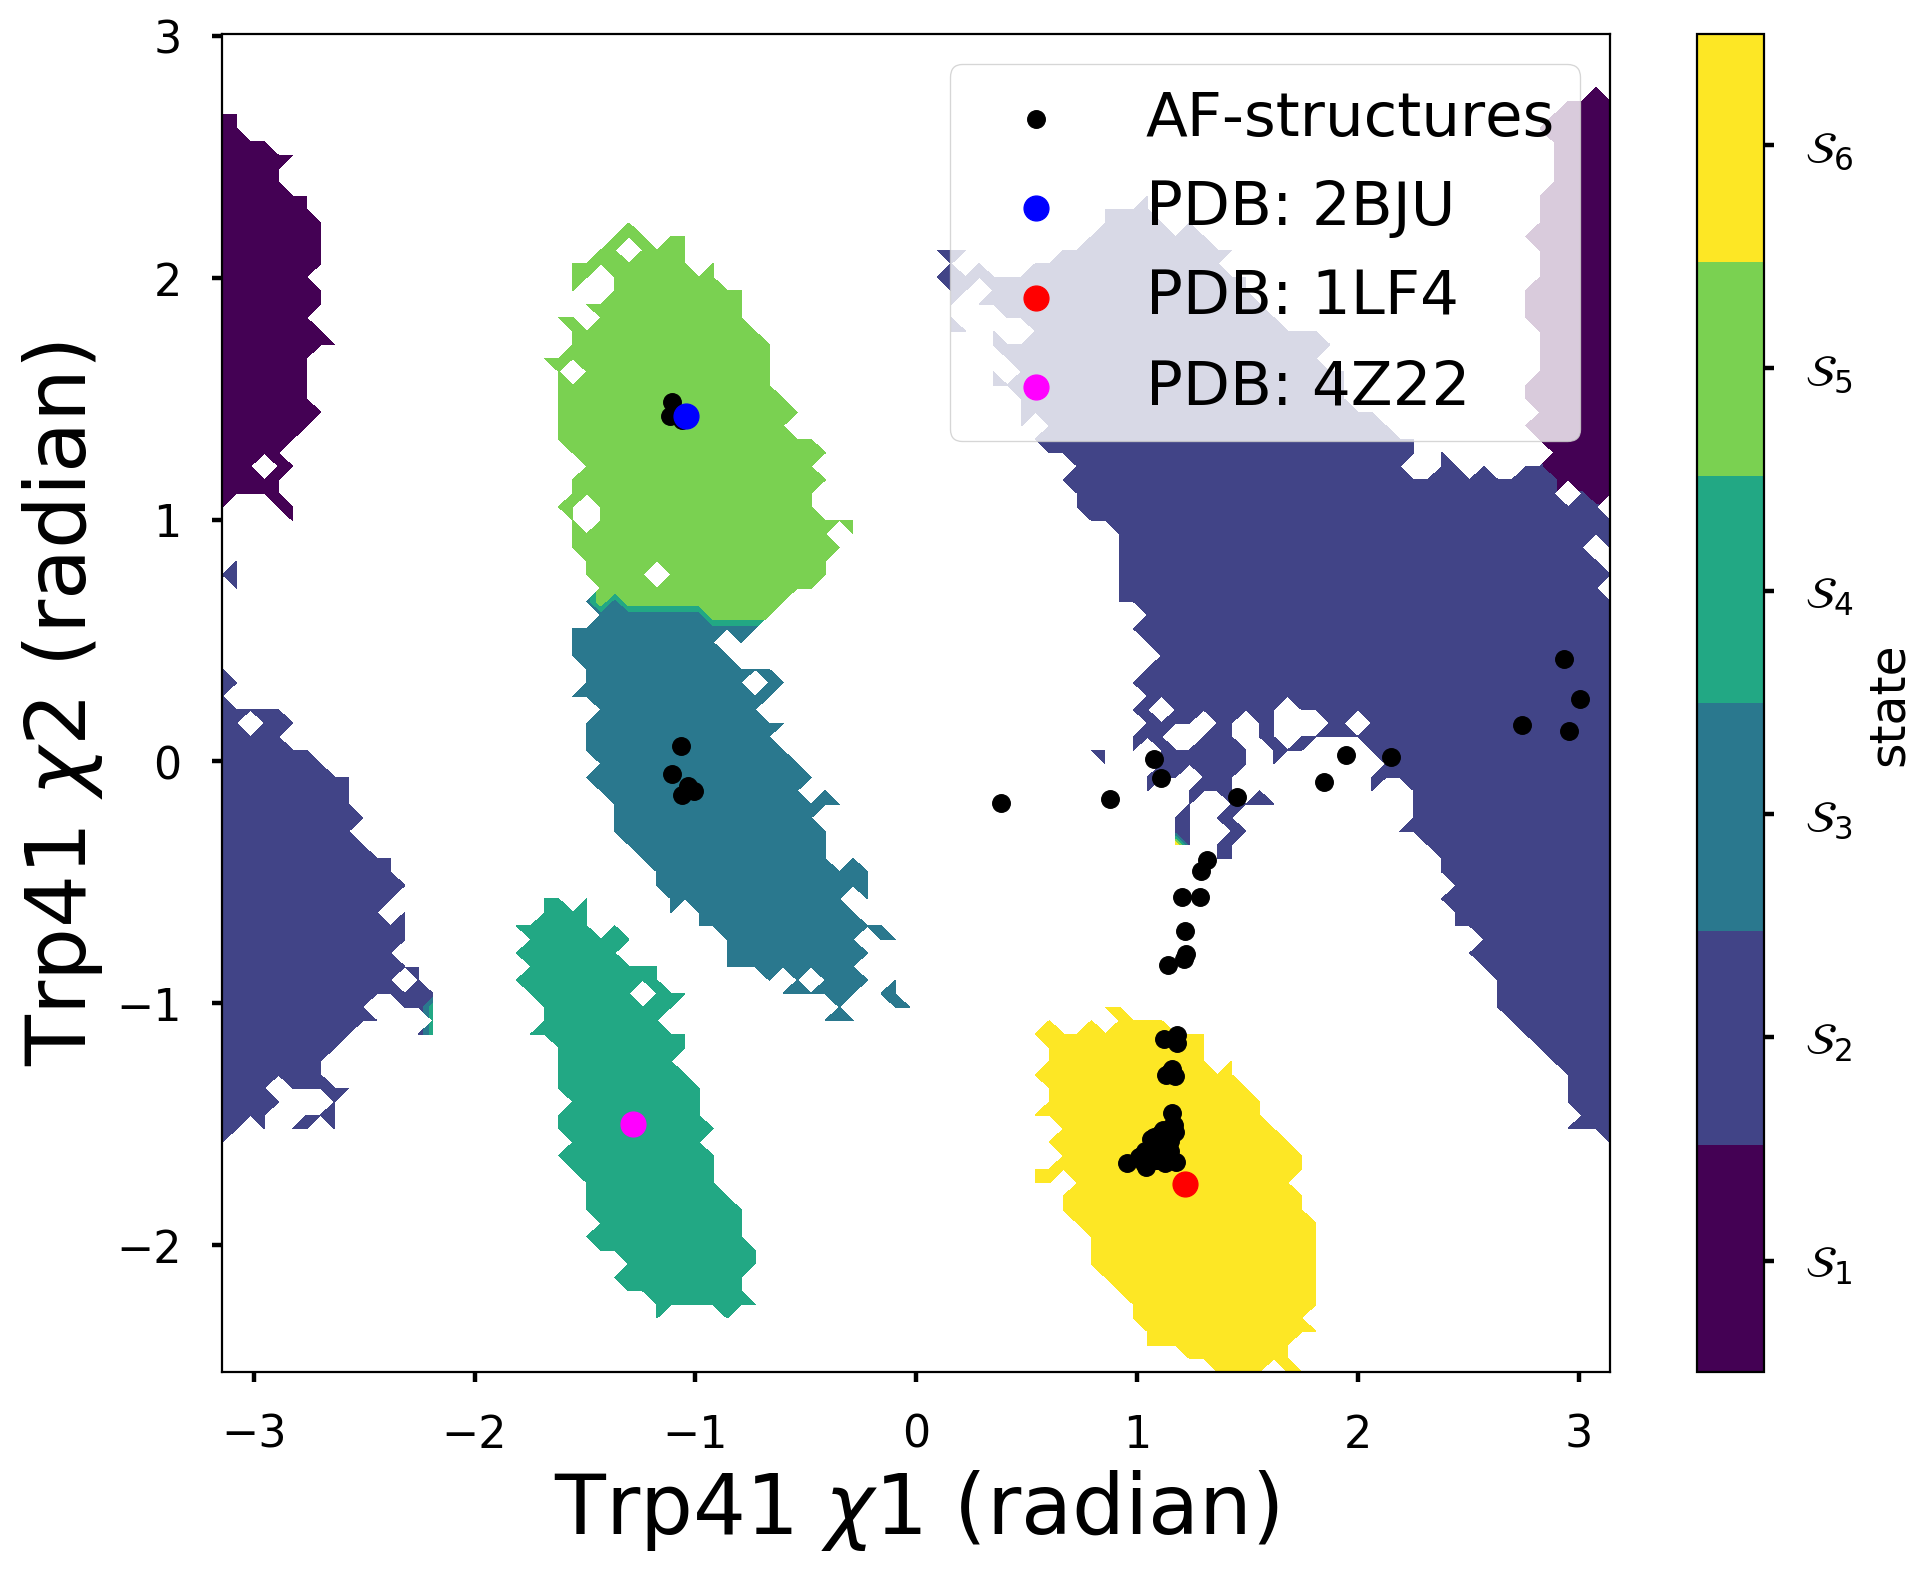

In [37]:
metastable_traj = msm.metastable_assignments[np.concatenate(msm.dtrajs_active)]

fig, ax = plt.subplots(figsize=(10, 8))
_, _, misc = pyemma.plots.plot_state_map(
    *features_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('Trp41 $\chi1$ (radian)', fontsize=30)
ax.set_ylabel('Trp41 $\chi2$ (radian)', fontsize=30)
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
ax.scatter(chi1, chi2, color='black', s=40, marker="o", label='AF-structures')
ax.scatter(chi12bju, chi22bju, color='blue', s=80, marker="o", label='PDB: 2BJU')
ax.scatter(chi11lf4, chi21lf4, color='red', s=80, marker="o", label='PDB: 1LF4')
ax.scatter(chi14z22, chi24z22, color='magenta', s=80, marker="o", label='PDB: 4Z22')
ax.legend(loc='upper right', fontsize=22)
fig.tight_layout()

## MFPT 

In [30]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT (ns)')
DataFrame(np.round(mfpt /50, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT (ns)


,1,2,3,4,5,6
1,0.00,727230.17,47852.34,243621.42,59303.36,2273.09
2,989215.42,0.00,41122.91,218853.15,46303.27,4143.83
3,1760384.07,1432950.63,0.00,215268.20,49631.42,2643.37
4,1742355.99,1394699.44,2546.80,0.00,49205.74,2943.15
5,1759901.33,1425501.49,37697.52,250468.78,0.00,8267.96
6,1766250.57,1448493.02,54046.46,267620.64,71664.45,0.00


In [31]:
df_mfpt = DataFrame(np.round(mfpt /50, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

In [32]:
import seaborn as sns

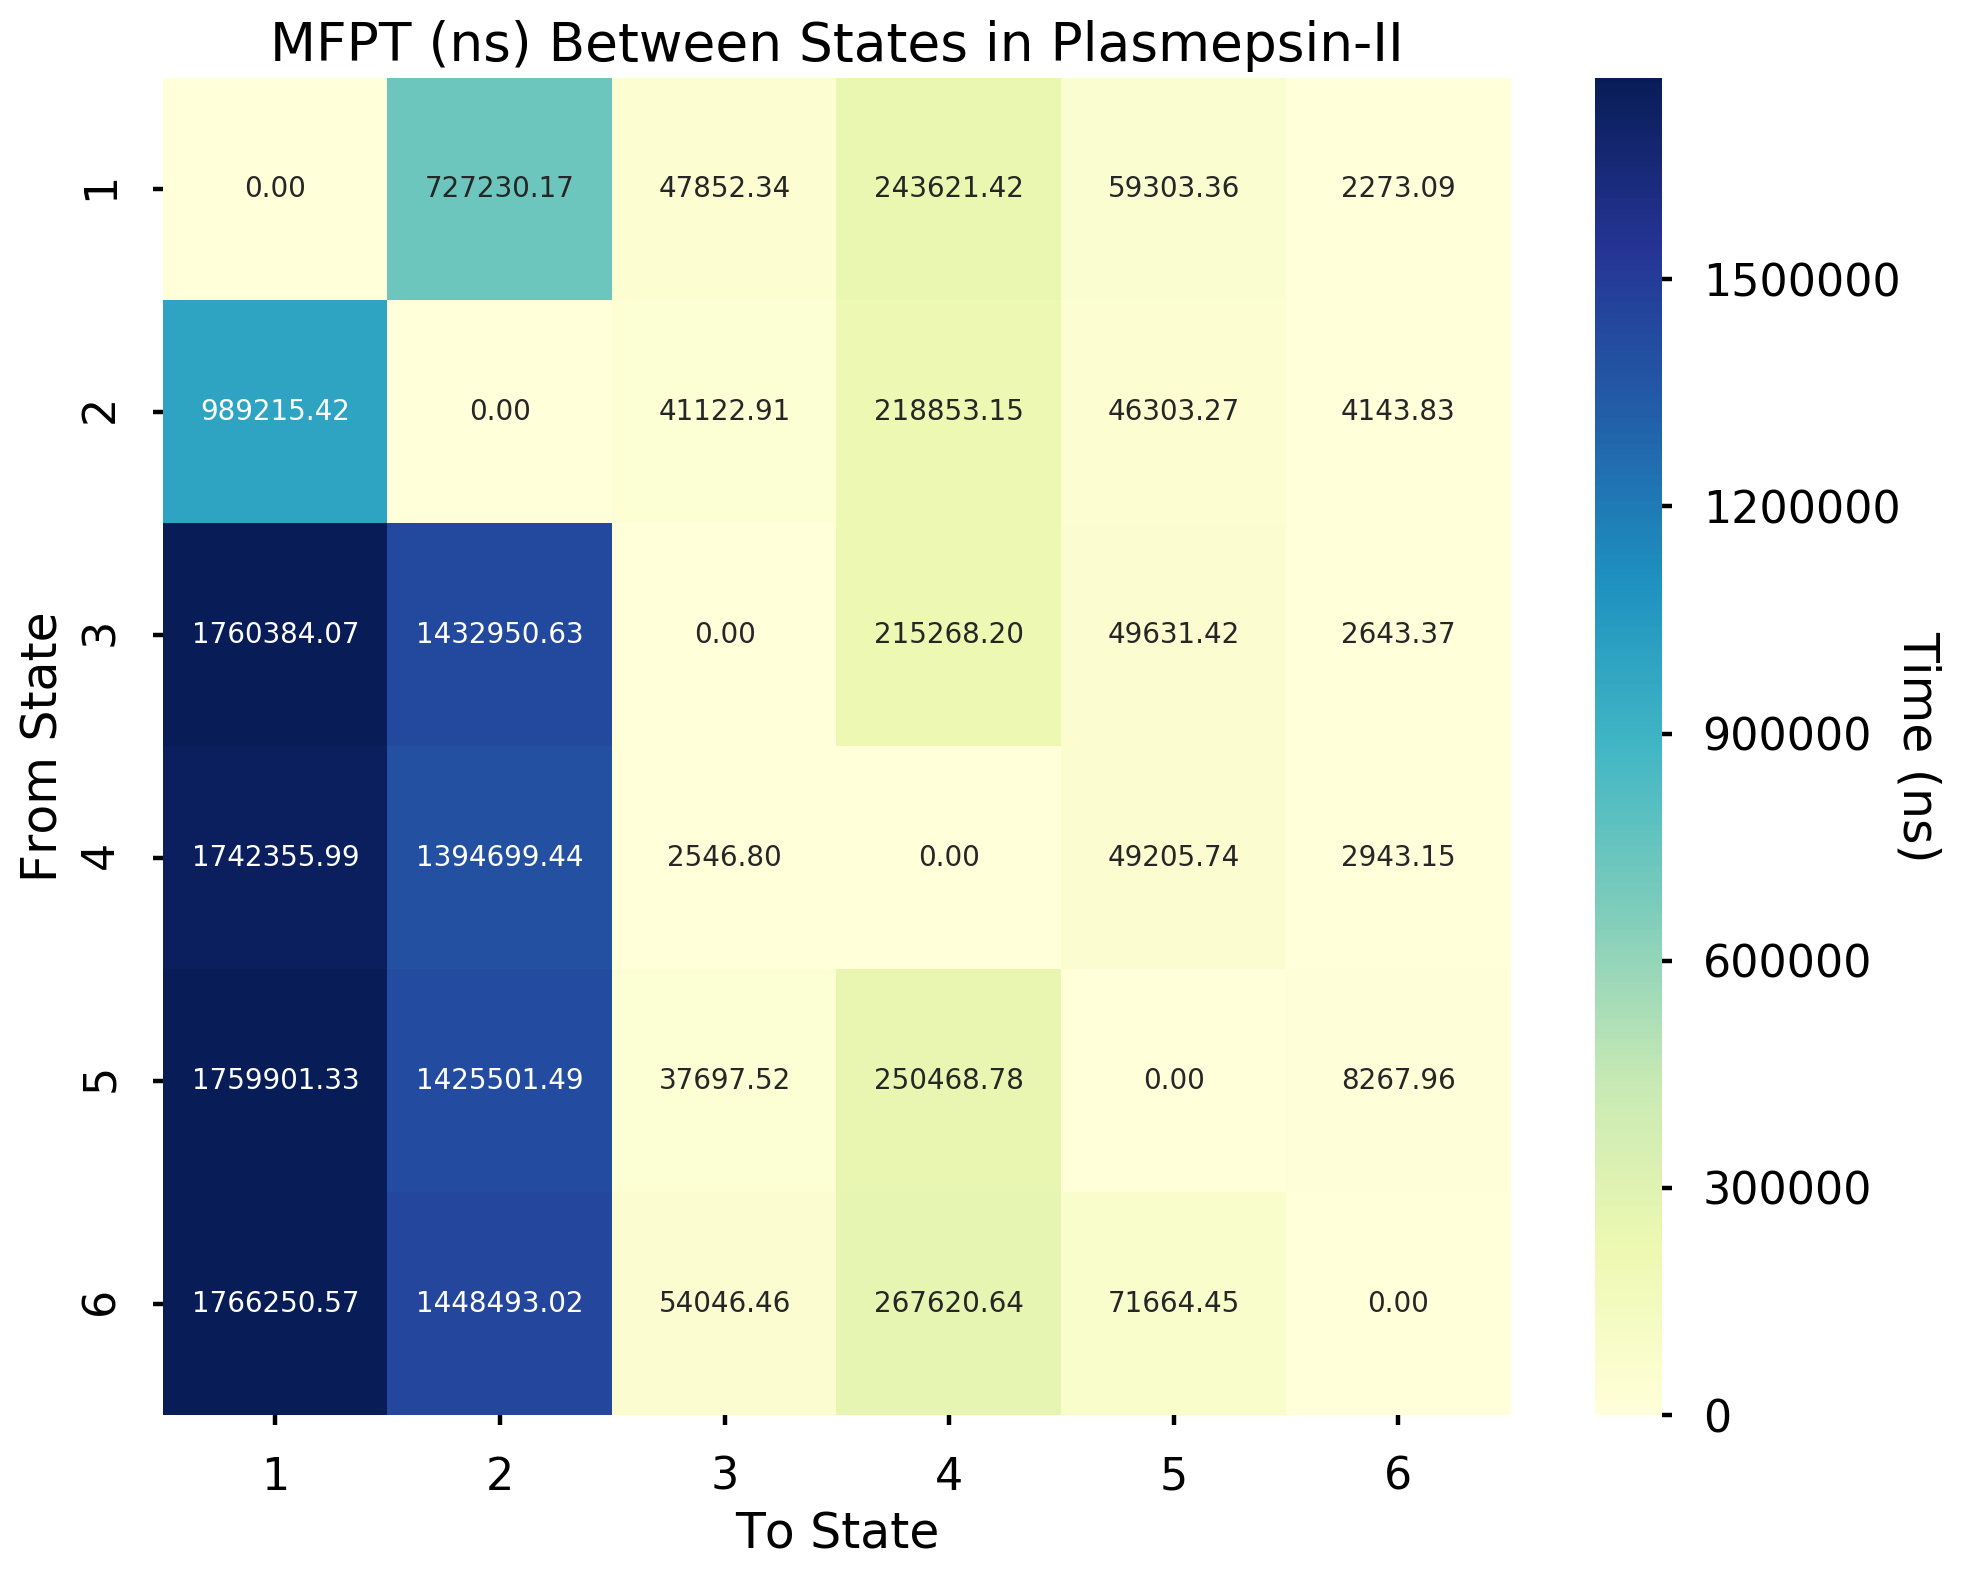

In [33]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_mfpt, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("MFPT (ns) Between States in Plasmepsin-II")
plt.xlabel("To State")
plt.ylabel("From State")

cbar = heatmap.collections[0].colorbar
cbar.set_label("Time (ns)", labelpad=15, rotation=270)

plt.tight_layout()
plt.show()